In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from smart_simulation.cfg_templates.config import package_dir
from smart_simulation.outputs import output_utils as ou
from smart_simulation.ds_tools import data_eng as de
from smart_simulation.ds_tools import eda
from app import forecasting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
weights_file_list = ou.weight_files()
servings_file_list = ou.servings_files()

# EDA
## Quick Visualization and data clean up
### Raw Weight Visualization

In [4]:
sample = de.load_sim_data(weights_file_list[-1], ['weight'])
eod_weights = de.eod_weights(sample.weight)
eod_weight_peaks = eda.find_weight_peaks(weight_series = eod_weights)

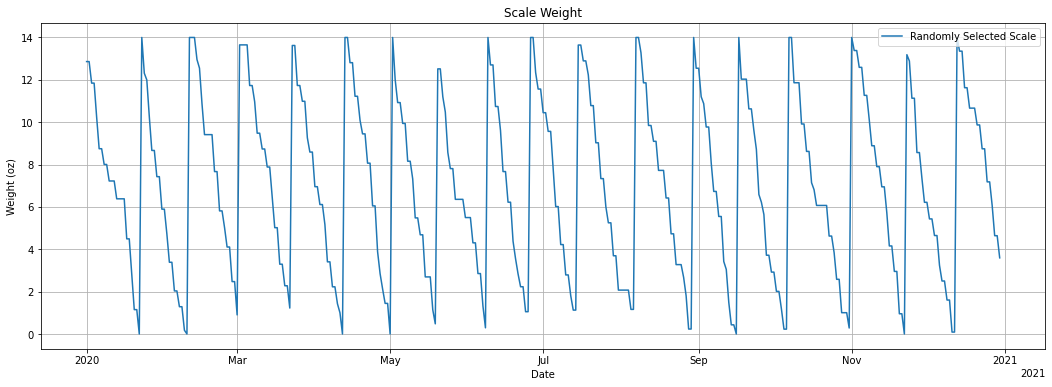

In [5]:
eda.plot_weights(eod_weights, 'Scale Weight', 'Randomly Selected Scale', bar = False)

### Consumption Visualization
#### Raw Consumption Calculation

In [6]:
raw_consumption = de.calculate_consumption(weight_series = eod_weights, adjustments = None)

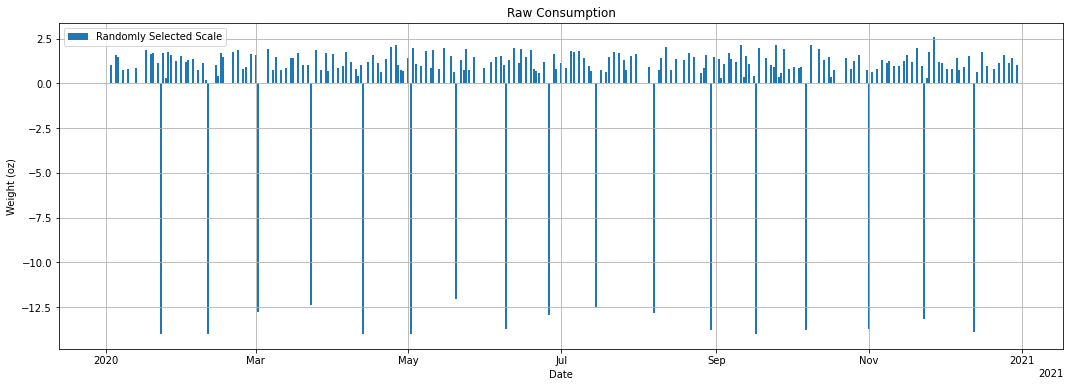

In [7]:
eda.plot_weights(raw_consumption, 'Raw Consumption', 'Randomly Selected Scale', bar = True)

#### Find Product Arrival Dates to Fix Consumption Outliers

In [8]:
estimated_peaks = eda.find_weight_peaks(weight_series = eod_weights)
segments = eda.create_consumption_segments(weight_series = eod_weights, peaks = estimated_peaks)
segments_data = eda.create_segments_data(consumption_segments = segments, weight_series = eod_weights)
segments_misaligned = eda.segments_misaligned(segments_data = segments_data)

print(f"\nBreak Point Segments Misaligned: {segments_misaligned}\n")
segments_data


Break Point Segments Misaligned: False



,time_delta,start_time,max_weight_time,end_time,min_weight_time,start_weight,max_weight,end_weight,min_weight
0,21 days,2020-01-01,2020-01-01,2020-01-22,2020-01-22,12.861788,12.861788,0.000000,0.000000
1,18 days,2020-01-23,2020-01-23,2020-02-10,2020-02-10,14.000000,14.000000,0.000000,0.000000
2,19 days,2020-02-11,2020-02-11,2020-03-01,2020-03-01,14.000000,14.000000,0.900817,0.900817
3,20 days,2020-03-02,2020-03-02,2020-03-22,2020-03-22,13.649749,13.649749,1.223625,1.223625
4,20 days,2020-03-23,2020-03-23,2020-04-12,2020-04-12,13.621779,13.621779,0.000000,0.000000
5,18 days,2020-04-13,2020-04-13,2020-05-01,2020-05-01,14.000000,14.000000,0.000000,0.000000
6,17 days,2020-05-02,2020-05-02,2020-05-19,2020-05-19,14.000000,14.000000,0.478759,0.478759
7,19 days,2020-05-20,2020-05-20,2020-06-08,2020-06-08,12.516940,12.516940,0.290924,0.290924
8,16 days,2020-06-09,2020-06-09,2020-06-25,2020-06-25,14.000000,14.000000,1.051156,1.051156
9,18 days,2020-06-26,2020-06-26,2020-07-14,2020-07-14,14.000000,14.000000,1.126692,1.126692


In [9]:
estimated_peaks

[Timestamp('2020-01-23 00:00:00'),
 Timestamp('2020-02-11 00:00:00'),
 Timestamp('2020-03-02 00:00:00'),
 Timestamp('2020-03-23 00:00:00'),
 Timestamp('2020-04-13 00:00:00'),
 Timestamp('2020-05-02 00:00:00'),
 Timestamp('2020-05-20 00:00:00'),
 Timestamp('2020-06-09 00:00:00'),
 Timestamp('2020-06-26 00:00:00'),
 Timestamp('2020-07-15 00:00:00'),
 Timestamp('2020-08-07 00:00:00'),
 Timestamp('2020-08-30 00:00:00'),
 Timestamp('2020-09-17 00:00:00'),
 Timestamp('2020-10-07 00:00:00'),
 Timestamp('2020-11-01 00:00:00'),
 Timestamp('2020-11-23 00:00:00'),
 Timestamp('2020-12-13 00:00:00')]

#### Clean up consumption calculations

In [10]:
arrival_time_stamps = estimated_peaks # segments_data.start_time[1:]
index = pd.DatetimeIndex(arrival_time_stamps).rename(None)
adjustments = pd.Series(14.0, index = index, dtype = float, name = 'weight')

In [11]:
daily_consumption = de.calculate_consumption(weight_series = eod_weights, adjustments = adjustments)

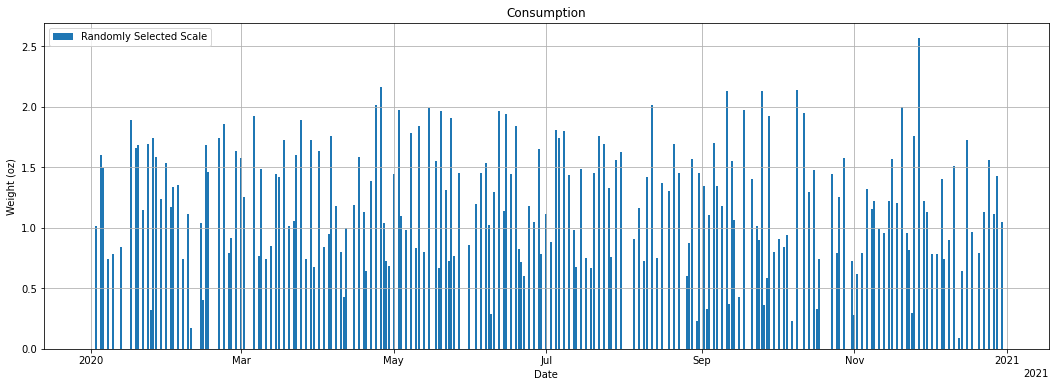

In [12]:
eda.plot_weights(daily_consumption, 'Consumption', 'Randomly Selected Scale', bar = True)

# Modeling Approach
## What are we trying to answer?
An end to end smart subscription contains multiple components. Right now were are just considering the ordering process.
**When should a new order be triggered for customer (X) for just-in-time delivery of product (a)?**

### Question subcomponents
1. Shipping duration estimate
- How long will shipping take for product (a) to reach customer (X)?
2. Remaining life of customer's current stock estimate
- How many days of consumption of product (a) does customer (X) have left in current stock?

Currently we're trying to answer question (2).


### Brief review of a few constraints
1. The weight/stock is directly influenced by the customer's consumption
2. As long as there is product available, we can assume future consumption on a long enough timeline
3. Scale weight measurement error does occur
4. New bags come in a variety of weights (12oz, 32oz, etc.)
5. Scale weight should fall within an expected range  
    - minimum = 0  
    - maximum = weight of last bag shipped to customer + prexisting measurement at last bag arrival  

### Forecasting options
We have two general paths we can take to answer our question: How many days of consumption of product (a) does customer (X) have left in current stock?
1. Forecast expected number of days left using historic weight
    - forecast future weight using historic weight
    - set a threshold, likely 0 or some number representing '1 day of consumption left' 
    - find the timestamp where the forecast crosses the threshold
2. Forecast expected number of days left using historic consumption
    - calculate consumption from historic weight  
    - forecast consumption  
    - set a threshold, likely 0 or some number representing '1 day of consumption left'  
    - find the timestamp where the forecast crosses the threshold  

For the sake of simplicity we might think option (1) would be better, because we have one less step listed. However, asssume there are subcomponents to each step. We also haven't given the problem constraints much consideration.

#### Detailed assessment of options
1. Forecasts should assume no replenishment within forecast period. Put another way, we need to assume a contantly diminishing stock.
    - **Weight based forecast**
        - weight series requires correction
            - could calculate an **infinite** weight series, essentially a backwards cumulative weight
    - **Consumption based forecast**
        - Earlier in the EDA portion we already saw how we can correct consumption on replenishment days
2. Expect some missing or bad data in weight measurements
    - **Weight based forecast**
        - Difficult to correct, because weight at timestamp t is dependent on weight at t-1
        - Possible solution would use a pseudo or expected consumption
            - solution space traveling: weight -> consumption - weight
            - non-optimal path
    - **Consumption based forecast**
        - We have historic values we can use to create a correction method
            - consumption at timestamp t is, for the most part, independent on consumption at t-1 
                - consumer might self-ration, but unlikely, or infrequent
                - consumption at time t-1 might indicate availability of consumer (in town/out of town) but that is not true dependence
3. There will be days where no product is available for consumption (AKA stock is empty)
    - **Weight based forecast**
        - Weight values for days with no available product for consumption will innaccurately describe consumer behavior
        - This would be difficult to continually correct for the same reason in # 3
    - **Consumption based forecast**
        - Again, we have historic values we can use to create a correction method        

All that to say **consumption is a simplified solution allows for more flexibilty when we come across problems with modeling**.

Lets now reframe our question:
**Given the current weight and historic consumption, how many remaining days of available consumption remain?**

## Forecast: Remaining Days of Available Consumption

### Raw Scale Weight
Lets take a quick look at our raw weight values again.

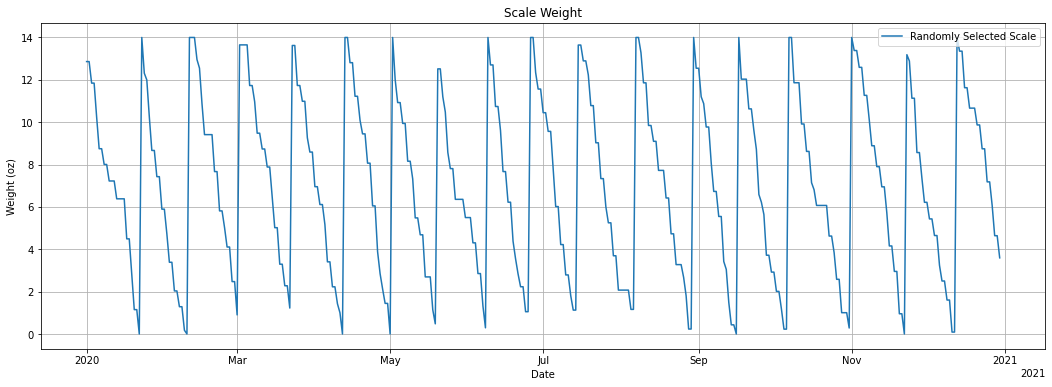

In [13]:
eda.plot_weights(eod_weights, 'Scale Weight', 'Randomly Selected Scale', bar = False)

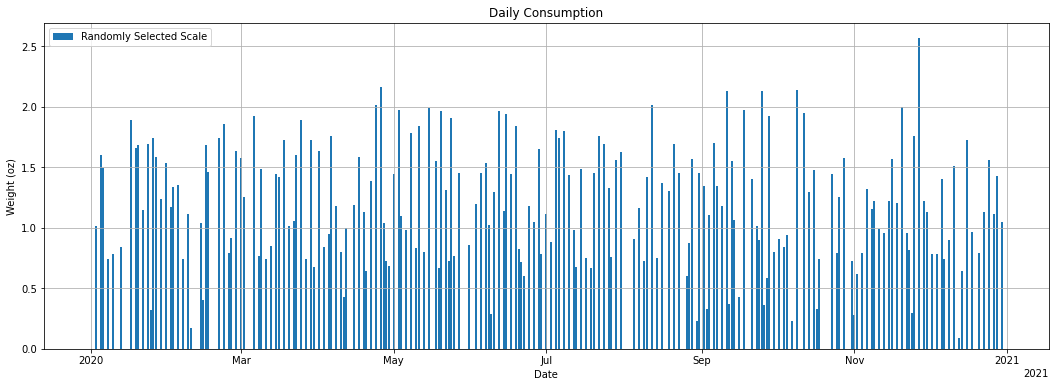

In [14]:
eda.plot_weights(daily_consumption, 'Daily Consumption', 'Randomly Selected Scale', bar = True)

In [15]:
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sklearn.metrics import mean_absolute_error as MAE

In [16]:
dc = daily_consumption.copy().asfreq('1D')
y_train, y_test = temporal_train_test_split(dc, test_size=10)

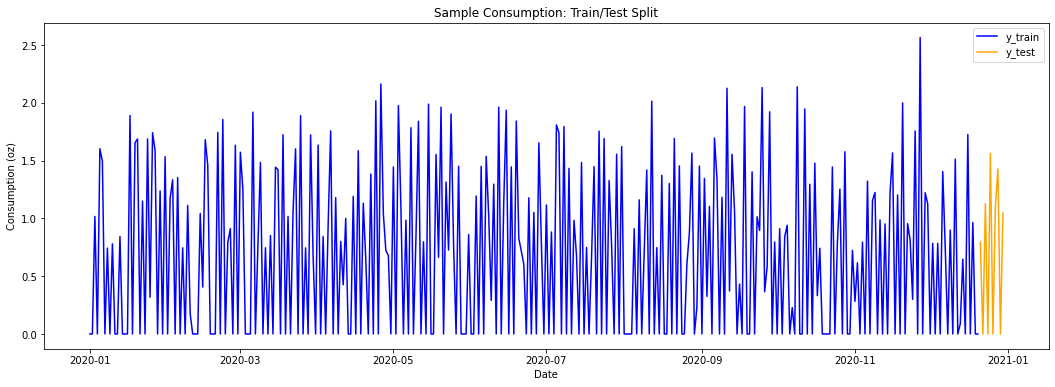

In [17]:
fig = plt.figure(figsize=(18, 6))
plt.plot(y_train, color = 'blue', label ='y_train')
plt.plot(y_test, color = 'orange', label ='y_test')
plt.title('Sample Consumption: Train/Test Split')
plt.xlabel('Date')
plt.ylabel('Consumption (oz)')
plt.legend()
plt.show()

In [18]:
fh = np.arange(1, len(y_test) + 1)
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### Niave Forecasting

In [19]:
from sktime.forecasting.naive import NaiveForecaster

In [20]:
sma_forecaster = NaiveForecaster(strategy="mean", window_length=7)
sma_forecaster.fit(y_train)
sma_y_pred = sma_forecaster.predict(fh)

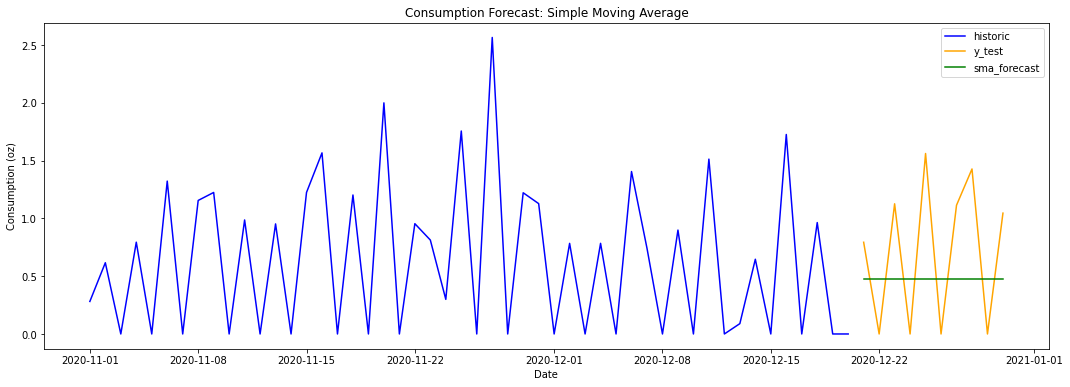

In [21]:
fig = plt.figure(figsize=(18, 6))
plt.plot(y_train[-50:], color = 'blue', label ='historic')
plt.plot(y_test, color = 'orange', label ='y_test')
plt.plot(sma_y_pred, color = 'green', label ='sma_forecast')
plt.title('Consumption Forecast: Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Consumption (oz)')
plt.legend()
plt.show()

In [22]:
sma_mae = MAE(y_true = y_test, y_pred = sma_y_pred)
print(f"Mean Absolute Error: {sma_mae:.2}")

Mean Absolute Error: 0.61


### Stochastic Forecasting with Seasonal ARIMA

In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [31]:
model = SARIMAX(endog=y_train, order=(0,0,0), seasonal_order=(1,0,1,7))
model_fit = model.fit(disp=False)
sarima_y_pred = model_fit.forecast(steps=10)

In [32]:
forecast

2020-12-21    0.993636
2020-12-22    0.031915
2020-12-23    1.096550
2020-12-24    0.051952
2020-12-25    1.378057
2020-12-26    0.080614
2020-12-27    0.824497
Freq: D, Name: predicted_mean, dtype: float64

In [33]:
# from sktime.forecasting.arima import AutoARIMA
# sarima_forecaster = AutoARIMA(start_p=1, 
#                               d=None, 
#                               start_q=1, 
#                               max_p=7, 
#                               max_d=7, 
#                               max_q=7, 
#                               start_P=0, 
#                               D=None, 
#                               start_Q=0, 
#                               max_P=2, 
#                               max_D=1, 
#                               max_Q=2, 
#                               max_order=14, 
#                               sp=7, 
#                               test='adf',
#                               suppress_warnings=True, 
#                               error_action='warn', 
#                               trace=True, 
#                               out_of_sample_size=len(fh), 
#                               scoring='mse')

# sarima_forecaster = AutoARIMA(sp=7,suppress_warnings=True)
# sarima_forecaster.fit(y_train)
# sarima_y_pred = sarima_forecaster.predict(fh)

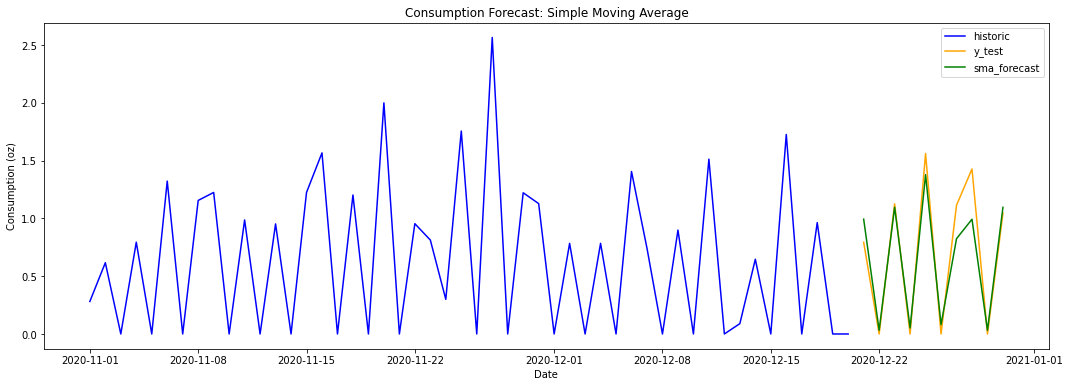

In [34]:
fig = plt.figure(figsize=(18, 6))
plt.plot(y_train[-50:], color = 'blue', label ='historic')
plt.plot(y_test, color = 'orange', label ='y_test')
plt.plot(sarima_y_pred, color = 'green', label ='sma_forecast')
plt.title('Consumption Forecast: Simple Moving Average')
plt.xlabel('Date')
plt.ylabel('Consumption (oz)')
plt.legend()
plt.show()

In [35]:
sarima_mae = MAE(y_true = y_test, y_pred = sarima_y_pred)
print(f"Mean Absolute Error: {sarima_mae:.2}")

Mean Absolute Error: 0.14


### Machine Learning with Random Forest Regression

In [37]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.ensemble import RandomForestRegressor

In [40]:
regressor=RandomForestRegressor(n_estimators=100)
rf_forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=10, strategy="recursive"
)
rf_forecaster.fit(y_train)
rf_y_pred = rf_forecaster.predict(fh)

In [41]:
# from sktime.forecasting.model_selection import (
#     ForecastingGridSearchCV,
#     SlidingWindowSplitter,
# )

# regressor=RandomForestRegressor(n_estimators=100)
# rf_forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=10, strategy="recursive"
# )
# param_grid = {"window_length": [5, 10, 15, 20, 25]}

# #  we fit the forecaster on the initial window,
# # and then use temporal cross-validation to find the optimal parameter
# cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.5))
# gscv = ForecastingGridSearchCV(rf_forecaster, cv=cv, param_grid=param_grid)
# gscv.fit(y_train)
# rf_y_pred = gscv.predict(fh)

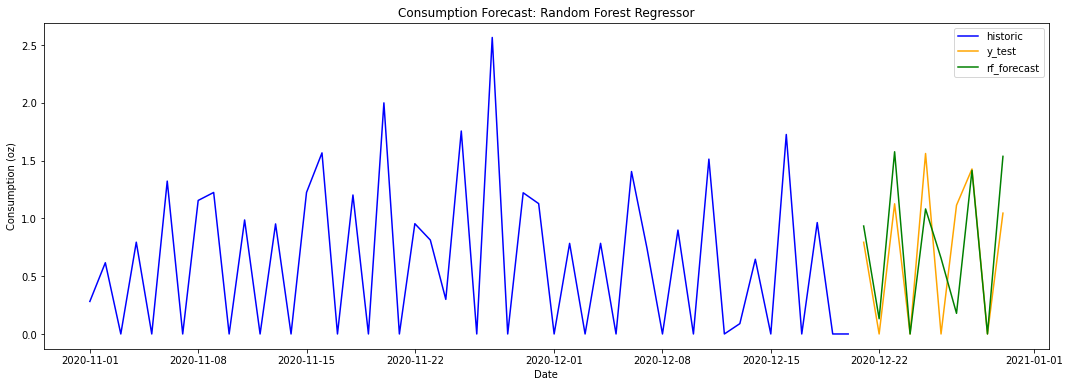

In [42]:
fig = plt.figure(figsize=(18, 6))
plt.plot(y_train[-50:], color = 'blue', label ='historic')
plt.plot(y_test, color = 'orange', label ='y_test')
plt.plot(rf_y_pred, color = 'green', label ='rf_forecast')
plt.title('Consumption Forecast: Random Forest Regressor')
plt.xlabel('Date')
plt.ylabel('Consumption (oz)')
plt.legend()
plt.show()

In [43]:
rf_mae = MAE(y_true = y_test, y_pred = rf_y_pred)
print(f"Mean Absolute Error: {rf_mae:.2}")

Mean Absolute Error: 0.33


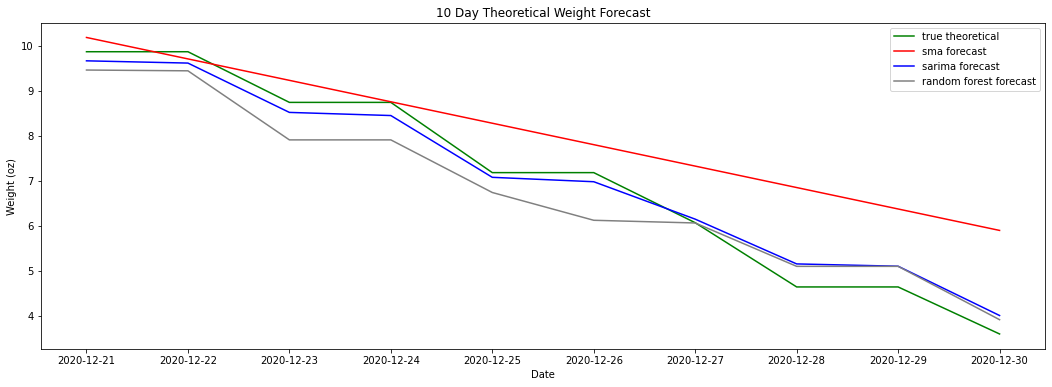

In [103]:
train_weights = eod_weights.loc[y_train.index]
test_weights = eod_weights.loc[y_test.index]

sma_y_pred = sma_y_pred.rename('consumption')
sarima_y_pred = sarima_y_pred.rename('consumption')
rf_y_pred = rf_y_pred.rename('consumption')


start_weight = train_weights[-1]
test_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=y_test)
sma_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=sma_y_pred)
sarima_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=sarima_y_pred)
rf_theoretical_weights = de.calculate_theoretical_weights(start_weight=start_weight, consumption_series=rf_y_pred)



# Plot
fig = plt.figure(figsize=(18, 6))
plt.plot(test_theoretical_weights, color ='green', label='true theoretical')
plt.plot(sma_theoretical_weights, color='red', label='sma forecast')
plt.plot(sarima_theoretical_weights, color='blue', label='sarima forecast')
plt.plot(rf_theoretical_weights, color='gray', label='random forest forecast')
plt.xlabel('Date')
plt.ylabel('Weight (oz)')

plt.title("10 Day Theoretical Weight Forecast")
plt.legend()
plt.show()

In [44]:
import statsmodels as sm
sm.__version__

'0.12.1'

In [69]:
sma_forecast, sarima_forecast, rf_forecast = forecasting.forecast_consumption(forecast_size=7, y_train=y_train)

In [70]:
sma_forecast

2020-12-21    0.476643
2020-12-22    0.476643
2020-12-23    0.476643
2020-12-24    0.476643
2020-12-25    0.476643
2020-12-26    0.476643
2020-12-27    0.476643
dtype: float64

In [71]:
sarima_forecast

2020-12-21    0.993636
2020-12-22    0.031915
2020-12-23    1.096550
2020-12-24    0.051952
2020-12-25    1.378057
2020-12-26    0.080614
2020-12-27    0.824497
Freq: D, Name: predicted_mean, dtype: float64

In [72]:
rf_forecast

2020-12-21    1.148092
2020-12-22    0.054365
2020-12-23    1.483513
2020-12-24    0.000000
2020-12-25    1.163434
2020-12-26    0.726407
2020-12-27    0.281621
dtype: float64

In [249]:
d = {1:'a'}
list(d.keys())

[1]

In [254]:
alt_table = y_train.reset_index().rename(columns={'index': 'date'})

In [264]:
all_consumption = pd.concat([y_train.rename('train'), y_test.rename('test')], axis=1).reset_index().rename(columns={'index': 'date'})

In [265]:
all_consumption

,date,train,test
0,2020-01-01,0.000000,NaN
1,2020-01-02,0.000000,NaN
2,2020-01-03,1.017081,NaN
3,2020-01-04,0.000000,NaN
4,2020-01-05,1.602583,NaN
...,...,...,...
360,2020-12-26,NaN,0.000000
361,2020-12-27,NaN,1.113872
362,2020-12-28,NaN,1.427703
363,2020-12-29,NaN,0.000000


In [ ]:
alt.Chart(all_consumption).mark_line().encode(x='date')

In [267]:
base = alt.Chart(all_consumption.reset_index()).encode(x='date')

alt.layer(
    base.mark_line(color='blue').encode(y='train'),
    base.mark_line(color='red').encode(y='test')
).interactive()

alt.LayerChart(...)

In [270]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [278]:
RANGE_SELECTOR = dict(
    buttons=list(
        [
            dict(count=1, label="1m", step="month", stepmode="backward",),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all"),
        ]
    )
)

RANGE_SLIDER = dict(visible=True)

LAYOUT = dict(
    xaxis=dict(
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward",),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="YTD", step="year", stepmode="todate"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    )
)


In [285]:
np.arange(7, 15)

array([ 7,  8,  9, 10, 11, 12, 13, 14])